## Import modules

In [1]:
from models.model_v1 import *
from data.midi_preprocessing import *
from utils.dataset_loader import *
from pytorch_lightning.callbacks import ModelCheckpoint

/usr/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Loss tracker and intermediate results callback

In [2]:
# Callback to track the loss of the minmax game.
class LossTracker(L.Callback):
    def __init__(self, latent_dim=100):
        self.g_losses = []
        self.d_losses = []
        self.conf_real = []
        self.conf_fake = []
        
        self.grad_norm = []

        # Used to see intermediate outputs after each epoch.
        self.validation_z = torch.randn(10, latent_dim)

    #def on_train_epoch_end(self, trainer, pl_module):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        g_loss = trainer.callback_metrics.get("g_loss")
        d_loss = trainer.callback_metrics.get("d_loss")
        conf_real = trainer.callback_metrics.get("conf_real")
        conf_fake = trainer.callback_metrics.get("conf_fake")

        grad_norm = trainer.callback_metrics.get("grad_norm")
        
        self.g_losses.append(g_loss.item())
        self.d_losses.append(d_loss.item())
        self.conf_real.append(conf_real.item())
        self.conf_fake.append(conf_fake.item())
        self.grad_norm.append(grad_norm.item())

        if batch_idx % 300 == 0:
            self.plot(pl_module)
            

    def plot(self, pl_module):
        display.clear_output(wait=True)

        z = self.validation_z.type_as(pl_module.generator.fc_net[0].weight)
        
        # Generate images.
        sample_curr = pl_module(z).detach().cpu()

        # Grid dimensions.
        cols = 5
        rows = 2

        # Plot intermediate results.
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
        axes = axes.flatten()
        for idx, (ax, img) in enumerate(zip(axes, sample_curr)):
            img_np = img.squeeze().numpy()
            im = ax.imshow(img_np, aspect="auto", origin="lower", cmap="hot")
            ax.set_title(f"#{idx}")
            fig.colorbar(im, ax=ax, label="Velocity")
        
        # Plot losses.
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))
        axes[0].plot(self.g_losses, label="Generator Loss")
        axes[0].plot(self.d_losses, label="Discriminator Loss")
        axes[0].set_xlabel("Iterations")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Losses")

        # Plot confidence.
        axes[1].plot(self.conf_real, label="Confidence real", color="green")
        axes[1].plot(self.conf_fake, label="Confidence fake", color="purple")
        axes[1].set_xlabel("Iterations")
        axes[1].set_ylabel("Confidence")
        axes[1].set_title("Discriminator Confidence")

        # Plot gradient norm.
        axes[2].plot(self.grad_norm, label="Gradient norm", color="red")
        axes[2].set_xlabel("Iterations")
        axes[2].set_ylabel("Gradient norm")
        axes[2].set_title("Generator Gradient Norm")

        for ax in axes:
            ax.legend()
            ax.grid(True)
        
        # Plot the figure.
        plt.tight_layout()
        plt.show()

## Setup

In [3]:
# Dataset path.
DATASET_PATH = "data/preprocessed/maestro-v3.0.0/dataset1/2006_50k_augmented.h5"

# Dataset from which we pick random samples.
dataset = MaestroV3DataSet(DATASET_PATH, mode="single")

In [4]:
# Define batch size.
BATCH_SIZE = 72

# Define the datamodule.
datamodule = MaestroV3DataModule(
    DATASET_PATH,
    mode="single",
    batch_size=BATCH_SIZE,
    preload_gpu=True
)

# Define latent dim (noise in Generator input)
LATENT_DIM = 100

# Define the loss tracker callback.
loss_tracker = LossTracker(latent_dim=LATENT_DIM)

# Define the checkpoint callback.
checkpoint_callback = ModelCheckpoint(
        filename="fa_classifier_{epoch:02d}", # Log each epoch.
        every_n_epochs=1,
        save_top_k=-1
    )

In [5]:
# Create the GAN.
model = GAN(
    lr_d=0.00001,
    lr_g = 0.0003,
    b1=0.5,
    b2=0.999,
    lambda_1=0.1,
    lambda_2=1,
    latent_dim=100,
    gen_updates=3,
    dis_updates=1,
    mbd_B_dim=10,
    mbd_C_dim=5,
    a=200,
    apply_mbd=True
)

# Define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    callbacks=[loss_tracker, checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the GAN

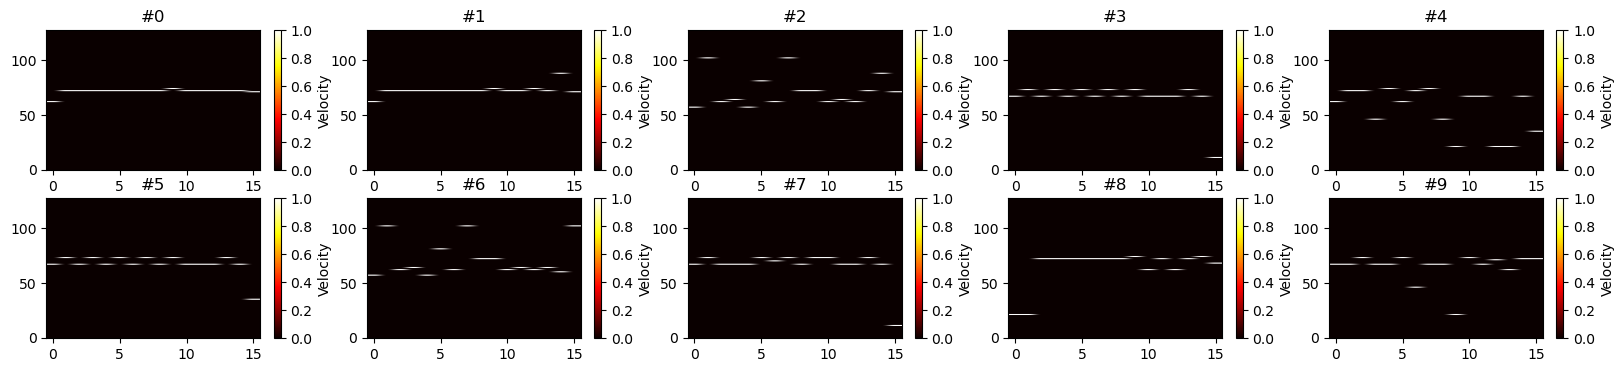

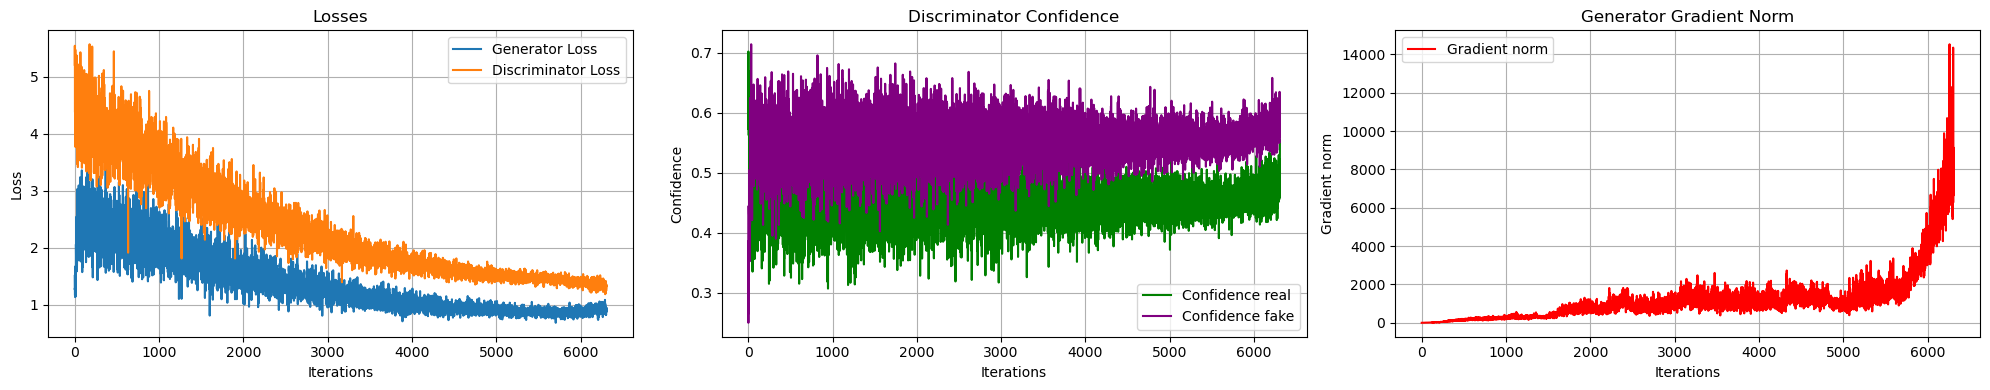

Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 634/634 [00:11<00:00, 53.78it/s, v_num=17, d_loss=1.350, conf_real=0.501, conf_fake=0.526, g_loss=0.788, grad_norm=6.89e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 634/634 [00:11<00:00, 53.71it/s, v_num=17, d_loss=1.350, conf_real=0.501, conf_fake=0.526, g_loss=0.788, grad_norm=6.89e+3]


In [6]:
trainer.fit(model, datamodule)

## Test model

In [9]:
# Set model in evaluation.
model.eval()

# Generate a sample.
z_lst = []
for _ in range(3):
    noise = torch.randn(1, 100)
    #print(noise)
    z_lst.append(noise)
hat_y = []
for z in z_lst:
    hat_y.append(model(z))

(128, 16)


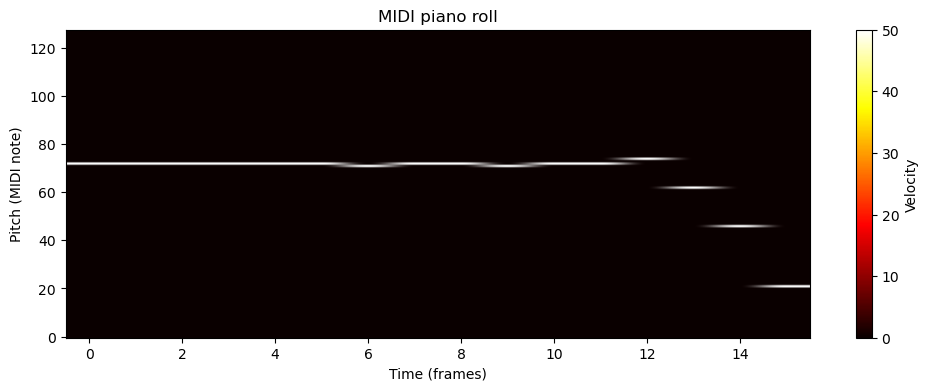

(128, 16)


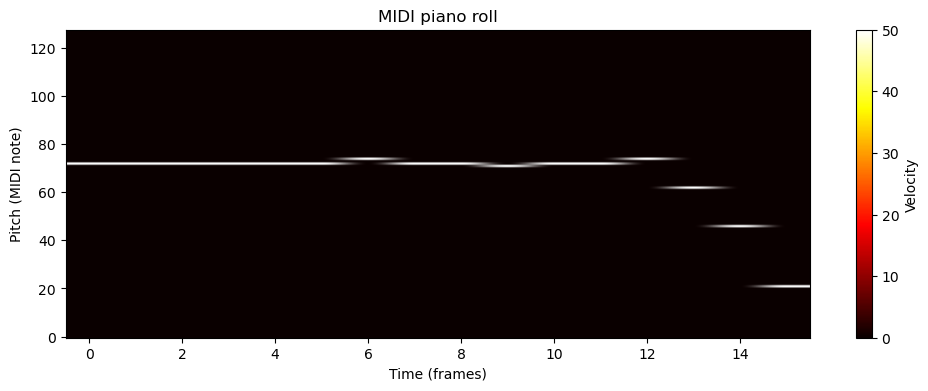

(128, 16)


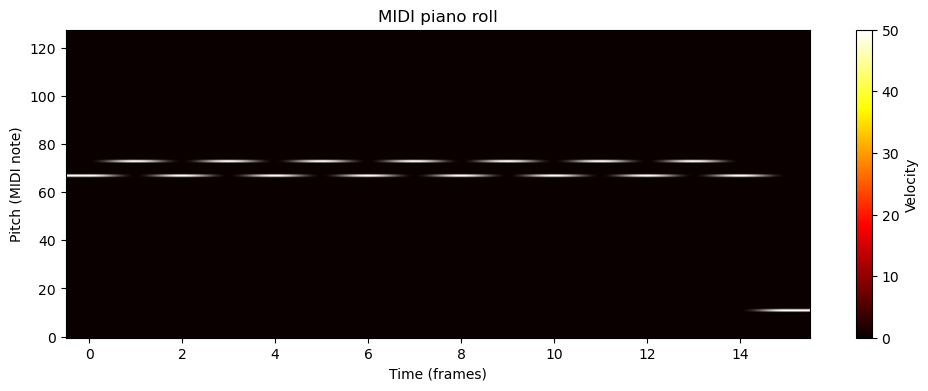

In [10]:
pr_lst = []
for i, y in enumerate(hat_y):
    # From tensor to numpy.
    y = y.squeeze(0, 1)
    pr = y.detach().numpy()
    pr *= 50
    print(pr.shape)

    # Print piano roll.
    show_piano_roll(pr)
    midi_file = piano_roll_to_pretty_midi(pr, fs=8)

    # Save midi to file.
    filename = "output_ex" + str(i) + ".midi"
    midi_file.write(filename)
    pr_lst.append(pr)